In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier  # Importa HistGradientBoostingClassifier (clasificación)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report

c:\Users\afric\anaconda3\envs\Sahara\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df_credit_reports= pd.read_parquet("credit_reports (1).parquet")
df_main_dataset=pd.read_parquet("main_dataset (1).parquet")

In [3]:
merged_df = df_main_dataset.merge(df_credit_reports, on='customer_id', how='inner')

In [4]:
merged_df.head(3)

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,...,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,SIN LIMITE PREESTABLECIDO,INDIVIDUAL (TITULAR),NaN,0,V,NaN,None,0.0,0.0,0.0
1,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),1.0,0,V,0.0,0,0.0,0.0,0.0
2,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),1.0,0,V,0.0,0,0.0,0.0,0.0


In [5]:
columnas_datetime = merged_df.select_dtypes(include=['datetime64']).columns
columnas_datetime

Index(['ACC_CREATION_DATETIME', 'APPLICATION_DATETIME',
       'LOAN_ORIGINATION_DATETIME', 'first_app_date', 'last_app_date',
       'first_bnpl_app_date', 'last_bnpl_app_date', 'INQUIRY_DATE',
       'UPDATE_DATE', 'LOAN_OPENING_DATE', 'LOAN_CLOSING_DATE',
       'WORST_DELAY_DATE', 'REPORT_DATE', 'LAST_PURCHASE_DATE',
       'LAST_PAYMENT_DATE'],
      dtype='object')

In [6]:
count_isnull = (merged_df.isnull().sum() /len(merged_df))*100
count_isnull[count_isnull>1]

n_sf_apps                  29.469369
first_app_date             29.469369
last_app_date              29.469369
n_bnpl_apps                 7.033784
n_bnpl_approved_apps        7.033784
first_bnpl_app_date         7.033784
last_bnpl_app_date          7.033784
CREDIT_LIMIT                2.908239
LOAN_CLOSING_DATE          32.971993
WORST_DELAY_DATE           70.538983
LAST_PURCHASE_DATE          1.441418
LAST_PAYMENT_DATE          11.023608
TOTAL_PAYMENTS              6.488467
WORST_DELAY                 1.117081
TOTAL_REPORTED_PAYMENTS    14.595484
dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

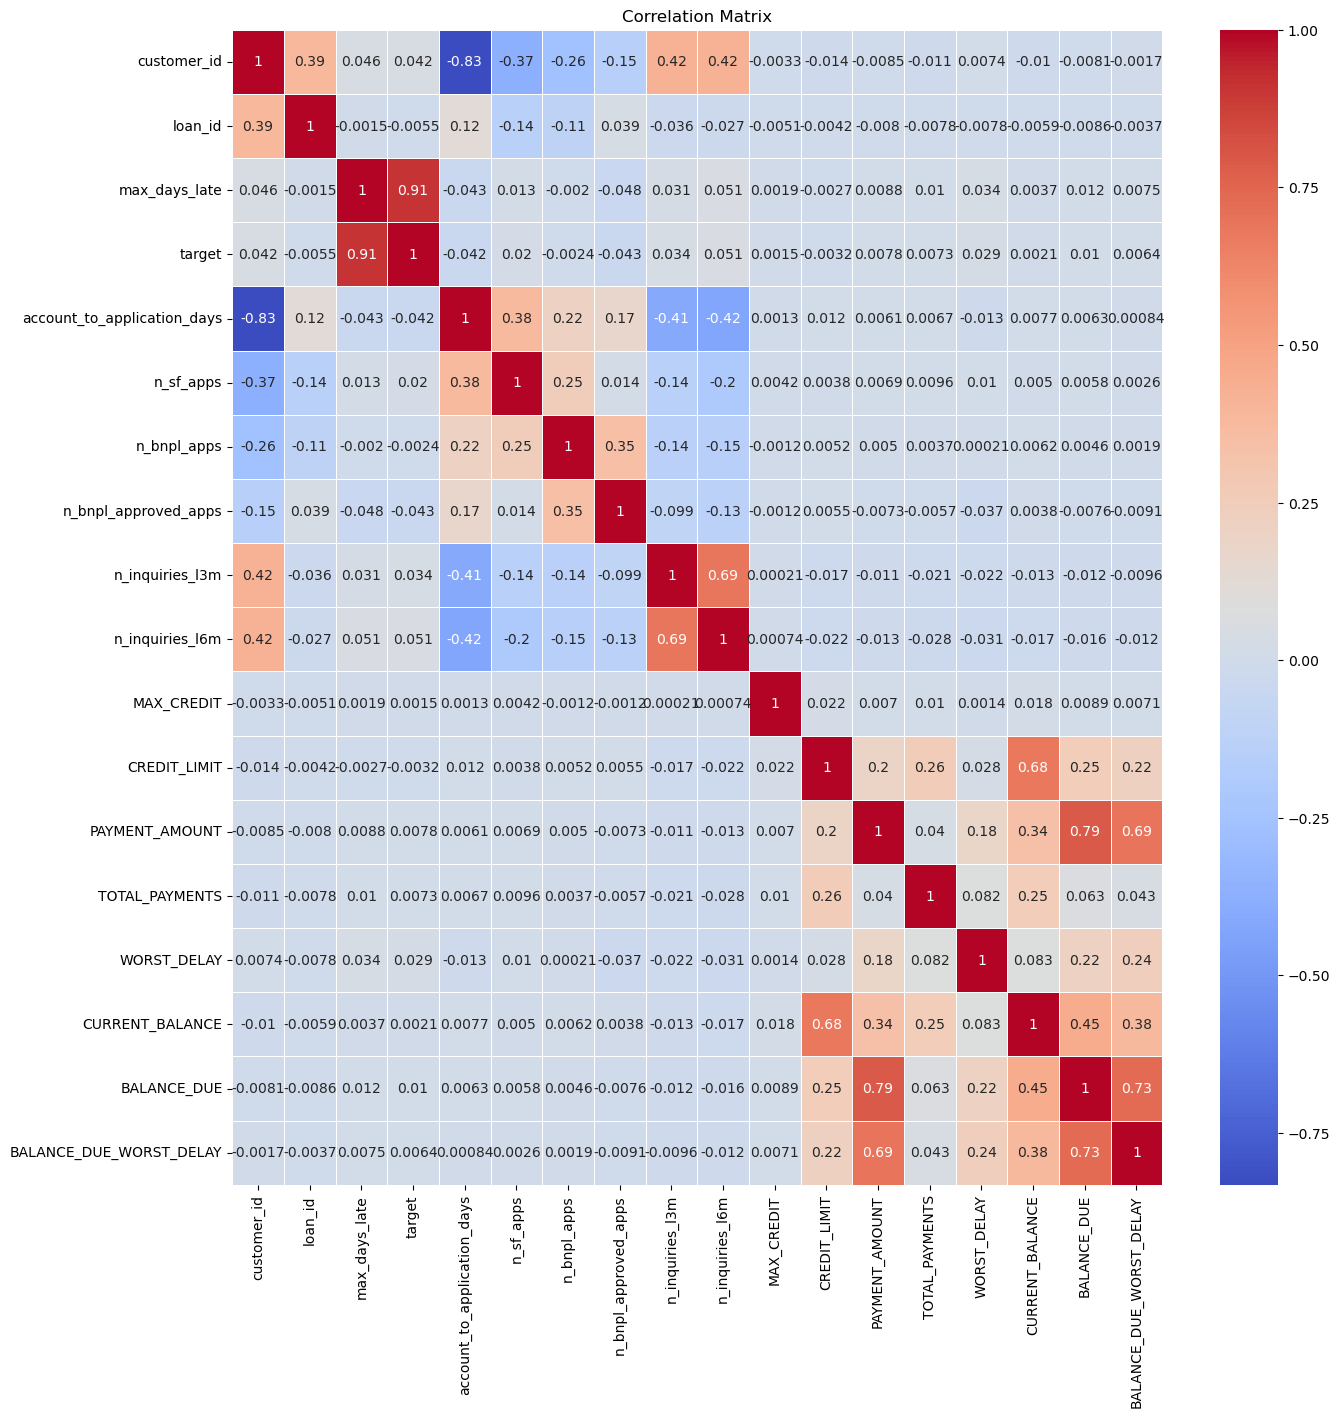

In [7]:
correlation_matrix = merged_df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')

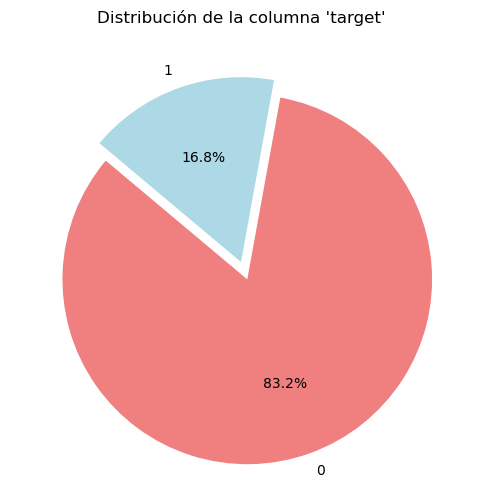

In [8]:
# Contar los valores en la columna "target" y también contar los valores nulos
target_counts = merged_df['target'].value_counts(dropna=False)

# Crear una figura para el gráfico de pastel
plt.figure(figsize=(6, 6))

# Etiquetas para los segmentos del gráfico
labels = [str(index) if not pd.isna(index) else 'Nulo' for index in target_counts.index]

# Valores de los segmentos del gráfico
sizes = target_counts.values

# Colores para los segmentos del gráfico
colors = ['lightcoral', 'lightblue']

# Explotar el segmento nulo
explode = (0.1, 0)

# Crear el gráfico de pastel
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Título
plt.title("Distribución de la columna 'target'")

# Mostrar el gráfico de pastel
plt.show()

### Valores no encontrados

Al tener en mente que se usara el modelo de HistGradientBoostClassifier para poder realizar una prediccion del comportamiento, utilizando la columna de "target" como la cual nos indica si el cliente es 1: Riesgoso, 0: no riesgoso.


Dado que difcho modelo permite el manejo de valores nulos, a todos aquellos que tienen menos del 10% de valores perdidos, no se realizará ninguna imputación, ya que el modelo lo soporta.

In [9]:
count_isnull[count_isnull>10]

n_sf_apps                  29.469369
first_app_date             29.469369
last_app_date              29.469369
LOAN_CLOSING_DATE          32.971993
WORST_DELAY_DATE           70.538983
LAST_PAYMENT_DATE          11.023608
TOTAL_REPORTED_PAYMENTS    14.595484
dtype: float64

Para el valor de n_sf_apps, colocaremos el valor de -1, el cual le indicará al modelo que ahi no existe valor, pero a su vez no creara falsos datos o datos estimados.

In [10]:
merged_df['n_sf_apps'].fillna(-1, inplace=True)

Al no tener los valores de las fechas, se estiman por medio de la interpolación lineal, esta nos permite estimar dichas fechas de una manera más precisa.

In [11]:
merged_df.sort_values('first_app_date', inplace=True)

merged_df['first_app_date'].interpolate(method='linear', inplace=True)

merged_df.sort_index(inplace=True)

In [12]:
merged_df.sort_values('last_app_date', inplace=True)

# Llena los valores faltantes utilizando la interpolación lineal
merged_df['last_app_date'].interpolate(method='linear', inplace=True)

# Restaura el orden original de los datos si es necesario
merged_df.sort_index(inplace=True)


In [13]:
merged_df.sort_values('LOAN_CLOSING_DATE', inplace=True)

merged_df['LOAN_CLOSING_DATE'].interpolate(method='linear', inplace=True)

merged_df.sort_index(inplace=True)

In [14]:
merged_df.sort_values('WORST_DELAY_DATE', inplace=True)

merged_df['WORST_DELAY_DATE'].interpolate(method='linear', inplace=True)

merged_df.sort_index(inplace=True)

In [15]:
merged_df.sort_values('LAST_PAYMENT_DATE', inplace=True)

merged_df['LAST_PAYMENT_DATE'].interpolate(method='linear', inplace=True)

merged_df.sort_index(inplace=True)

Para TOTAL_REPORTED_PAYMENTS al tener unicamente el valor de cero, colocaremos -1, para indicar que no tenemos registro alguno.

In [16]:
merged_df["TOTAL_REPORTED_PAYMENTS"].value_counts()

TOTAL_REPORTED_PAYMENTS
0    245415
Name: count, dtype: int64

In [17]:
merged_df['TOTAL_REPORTED_PAYMENTS'].fillna(-1, inplace=True)

Una vez rellenados los datos faltantes, cambiaremos con el método de label encoding, utilizando la biblioteca de sklearn

In [18]:
# Encuentra las columnas que no son numéricas
columnas_no_numericas = merged_df.select_dtypes(exclude=['number', 'datetime']).columns

# Inicializa el LabelEncoder
label_encoder = LabelEncoder()

# Itera a través de las columnas no numéricas y aplica LabelEncoder
for columna in columnas_no_numericas:
    merged_df[columna] = label_encoder.fit_transform(merged_df[columna])

### Ingeniería de Características

Duración de crédito promedio por cliente


Calcula la diferencia en días entre 'LOAN_CLOSING_DATE' y 'LOAN_OPENING_DATE' para cada cliente y calcula el promedio de esta duración para cada cliente.

In [19]:

# Asegúrate de que las columnas 'LOAN_CLOSING_DATE' y 'LOAN_OPENING_DATE' sean de tipo datetime
merged_df['LOAN_CLOSING_DATE'] = pd.to_datetime(merged_df['LOAN_CLOSING_DATE'])
merged_df['LOAN_OPENING_DATE'] = pd.to_datetime(merged_df['LOAN_OPENING_DATE'])

# Si ya están en formato datetime, puedes omitir la conversión.

# Calcula la diferencia en días entre las dos fechas
merged_df['loan_duration_days'] = (merged_df['LOAN_CLOSING_DATE'] - merged_df['LOAN_OPENING_DATE']).dt.days

# Agrupa por 'customer_id' y calcula el promedio de la duración del préstamo
average_loan_duration = merged_df.groupby('customer_id')['loan_duration_days'].mean().reset_index()



In [20]:
average_loan_duration

,customer_id,loan_duration_days
0,1,3021.250000
1,2,1278.800000
2,3,240.343750
3,4,331.846154
4,5,1669.755102
...,...,...
9244,14391,311.192308
9245,14404,435.269231
9246,14408,796.250000
9247,14410,122.974359


In [21]:
merged_df.merge(average_loan_duration, on='customer_id', how='inner')

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,...,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY,loan_duration_days_x,loan_duration_days_y
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,NaN,0,85,NaN,0,0.0,0.0,0.0,1427.0,781.240741
1,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,1.0,0,85,0.0,1,0.0,0.0,0.0,15.0,781.240741
2,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,1.0,0,85,0.0,1,0.0,0.0,0.0,4.0,781.240741
3,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,1.0,0,85,0.0,1,0.0,0.0,0.0,11.0,781.240741
4,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,1.0,0,85,0.0,1,0.0,0.0,0.0,23.0,781.240741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287351,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,3.0,11,1,1.0,1,634.0,634.0,634.0,829.0,492.200000
287352,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,1.0,11,1,1.0,1,263.0,263.0,263.0,775.0,492.200000
287353,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,3.0,10,3,3.0,1,3666.0,3666.0,3666.0,772.0,492.200000
287354,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,3.0,10,3,3.0,1,557.0,557.0,557.0,772.0,492.200000


 Antigüedad promedio de cuentas: 
 
 
 Calcula la diferencia en días entre 'UPDATE_DATE' y 'ACC_CREATION_DATETIME' para cada cliente y calcula el promedio de esta antigüedad para cada cliente.

In [22]:

# Asegúrate de que las columnas 'UPDATE_DATE' y 'ACC_CREATION_DATETIME' sean de tipo datetime
merged_df['UPDATE_DATE'] = pd.to_datetime(merged_df['UPDATE_DATE'])
merged_df['ACC_CREATION_DATETIME'] = pd.to_datetime(merged_df['ACC_CREATION_DATETIME'])

# Calcula la diferencia en días entre las dos fechas
merged_df['account_age_days'] = (merged_df['UPDATE_DATE'] - merged_df['ACC_CREATION_DATETIME']).dt.days

# Agrupa por 'customer_id' y calcula el promedio de la antigüedad de la cuenta
average_account_age = merged_df.groupby('customer_id')['account_age_days'].mean().reset_index()

merged_df.merge(average_account_age, on='customer_id', how='inner')

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,...,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY,loan_duration_days,account_age_days_x,account_age_days_y
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,0,85,NaN,0,0.0,0.0,0.0,1427.0,-1588.0,103.833333
1,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,0,85,0.0,1,0.0,0.0,0.0,15.0,-64.0,103.833333
2,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,0,85,0.0,1,0.0,0.0,0.0,4.0,-64.0,103.833333
3,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,0,85,0.0,1,0.0,0.0,0.0,11.0,-42.0,103.833333
4,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,0,85,0.0,1,0.0,0.0,0.0,23.0,-42.0,103.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287351,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,11,1,1.0,1,634.0,634.0,634.0,829.0,-24.0,-376.475000
287352,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,11,1,1.0,1,263.0,263.0,263.0,775.0,-24.0,-376.475000
287353,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,10,3,3.0,1,3666.0,3666.0,3666.0,772.0,-24.0,-376.475000
287354,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,10,3,3.0,1,557.0,557.0,557.0,772.0,-24.0,-376.475000


Frecuencia promedio de pagos:


Calcula la diferencia en días entre 'LAST_PAYMENT_DATE' y 'LAST_PURCHASE_DATE' para cada cliente y calcula el promedio de esta frecuencia de pagos para cada cliente.

In [23]:

# Asegúrate de que las columnas 'LAST_PAYMENT_DATE' y 'LAST_PURCHASE_DATE' sean de tipo datetime
merged_df['LAST_PAYMENT_DATE'] = pd.to_datetime(merged_df['LAST_PAYMENT_DATE'])
merged_df['LAST_PURCHASE_DATE'] = pd.to_datetime(merged_df['LAST_PURCHASE_DATE'])

# Calcula la diferencia en días entre las dos fechas
merged_df['payment_frequency_days'] = (merged_df['LAST_PAYMENT_DATE'] - merged_df['LAST_PURCHASE_DATE']).dt.days

# Agrupa por 'customer_id' y calcula el promedio de la frecuencia de pagos
average_payment_frequency = merged_df.groupby('customer_id')['payment_frequency_days'].mean().reset_index()

merged_df.merge(average_payment_frequency, on='customer_id', how='inner')

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,...,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY,loan_duration_days,account_age_days,payment_frequency_days_x,payment_frequency_days_y
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,85,NaN,0,0.0,0.0,0.0,1427.0,-1588.0,-1427.0,85.981132
1,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,85,0.0,1,0.0,0.0,0.0,15.0,-64.0,15.0,85.981132
2,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,85,0.0,1,0.0,0.0,0.0,4.0,-64.0,4.0,85.981132
3,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,85,0.0,1,0.0,0.0,0.0,11.0,-42.0,11.0,85.981132
4,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,85,0.0,1,0.0,0.0,0.0,23.0,-42.0,23.0,85.981132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287351,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,1,1.0,1,634.0,634.0,634.0,829.0,-24.0,53.0,209.026316
287352,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,1,1.0,1,263.0,263.0,263.0,775.0,-24.0,812.0,209.026316
287353,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,3,3.0,1,3666.0,3666.0,3666.0,772.0,-24.0,809.0,209.026316
287354,12079,14454,2022-12-24 17:19:26,2023-05-26 07:00:00,2023-05-29 12:18:28,0,0,152,1.0,2022-12-24,...,3,3.0,1,557.0,557.0,557.0,772.0,-24.0,809.0,209.026316


Relación entre consultas y aplicaciones: 


Calcula la proporción entre 'n_inquiries_l3m' y 'n_sf_apps' para medir la relación entre las consultas a informes de crédito y las solicitudes de financiamiento. 

In [24]:
# Calcula la proporción entre 'n_inquiries_l3m' y 'n_sf_apps'
merged_df['inquiry_to_application_ratio'] = merged_df['n_inquiries_l3m'] / merged_df['n_sf_apps']


Relación entre consultas y aprobaciones: 

Calcula la proporción entre 'n_inquiries_l3m' y 'n_bnpl_approved_apps' para medir la relación entre las consultas a informes de crédito y las aprobaciones de aplicaciones de financiamiento bnpl

In [25]:
merged_df['inquiry_to_approval_ratio'] = merged_df['n_inquiries_l3m'] / merged_df['n_bnpl_approved_apps']


In [26]:
merged_df.dtypes

customer_id                              int64
loan_id                                  int64
ACC_CREATION_DATETIME           datetime64[us]
APPLICATION_DATETIME            datetime64[us]
LOAN_ORIGINATION_DATETIME       datetime64[us]
max_days_late                            int64
target                                   int64
account_to_application_days              int64
n_sf_apps                              float64
first_app_date                  datetime64[us]
last_app_date                   datetime64[us]
n_bnpl_apps                            float64
n_bnpl_approved_apps                   float64
first_bnpl_app_date             datetime64[us]
last_bnpl_app_date              datetime64[us]
n_inquiries_l3m                        float64
n_inquiries_l6m                        float64
INQUIRY_TIME                             int32
CDC_INQUIRY_ID                           int32
INQUIRY_DATE                    datetime64[us]
PREVENTION_KEY                           int32
CURRENCY     

Contaremos los dias de relacion entre ellas, por ejemplo cuantos dias pasaron de que el cliente creo la cuenta y aplico a un credito

In [27]:
merged_df["creation_application"]=(merged_df["APPLICATION_DATETIME"] - merged_df["ACC_CREATION_DATETIME"]).dt.days

In [28]:
merged_df["origination_applicacion"]=(merged_df["LOAN_ORIGINATION_DATETIME"] - merged_df["APPLICATION_DATETIME"]).dt.days
merged_df["origination_creation"]=(merged_df["LOAN_ORIGINATION_DATETIME"] - merged_df["ACC_CREATION_DATETIME"]).dt.days


In [29]:
merged_df["application_age"]=(merged_df["last_app_date"]-merged_df["first_app_date"]).dt.days
merged_df["loan_last"]=(merged_df["last_app_date"]-merged_df["LOAN_ORIGINATION_DATETIME"]).dt.days
merged_df["loan_first"]=(merged_df["LOAN_ORIGINATION_DATETIME"]-merged_df["first_app_date"]).dt.days

In [30]:
merged_df["loan_first_bnpl"]=(merged_df["LOAN_ORIGINATION_DATETIME"]-merged_df["first_bnpl_app_date"]).dt.days
merged_df["last_loan_bnpl"]=(merged_df["last_bnpl_app_date"]-merged_df["LOAN_ORIGINATION_DATETIME"]).dt.days
merged_df["last_firsr_bnpl"]=(merged_df["last_bnpl_app_date"]-merged_df["first_bnpl_app_date"]).dt.days

In [31]:
merged_df['last_act'] = (merged_df["UPDATE_DATE"] - merged_df['INQUIRY_DATE']).dt.days
merged_df["today_act"] =(merged_df["REPORT_DATE"] - merged_df["UPDATE_DATE"]).dt.days


In [32]:
merged_df["AAC_WORST_DELAY_DATE"]=(merged_df["REPORT_DATE"]  - merged_df["WORST_DELAY_DATE"]).dt.days

In [33]:
merged_df["LOAN_OP_CL"]=(merged_df["LOAN_CLOSING_DATE"]-merged_df["LOAN_OPENING_DATE"]).dt.days

In [34]:
merged_df["LAST_PAY"]=(merged_df["REPORT_DATE"]  - merged_df["LAST_PAYMENT_DATE"]).dt.days
merged_df["PAY_PUR"]=(merged_df["LAST_PURCHASE_DATE"]  - merged_df["LAST_PAYMENT_DATE"]).dt.days
merged_df["LAST_PUR"]=(merged_df["REPORT_DATE"]  - merged_df["LAST_PAYMENT_DATE"]).dt.days

In [35]:
merged_df["AAC_LOAN_CLOSING_DATE"]=(merged_df["REPORT_DATE"] - merged_df["LOAN_CLOSING_DATE"]).dt.days

In [36]:
merged_df.dtypes

customer_id                           int64
loan_id                               int64
ACC_CREATION_DATETIME        datetime64[us]
APPLICATION_DATETIME         datetime64[us]
LOAN_ORIGINATION_DATETIME    datetime64[us]
                                  ...      
LOAN_OP_CL                          float64
LAST_PAY                            float64
PAY_PUR                             float64
LAST_PUR                            float64
AAC_LOAN_CLOSING_DATE               float64
Length: 67, dtype: object

In [37]:
merged_df.head(3)

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,...,last_loan_bnpl,last_firsr_bnpl,last_act,today_act,AAC_WORST_DELAY_DATE,LOAN_OP_CL,LAST_PAY,PAY_PUR,LAST_PUR,AAC_LOAN_CLOSING_DATE
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,-178.0,0.0,-1832.0,-50.0,-2234.0,1427.0,1434.0,1427.0,1434.0,7.0
1,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,-178.0,0.0,-308.0,0.0,-660.0,15.0,64.0,-15.0,64.0,64.0
2,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,-178.0,0.0,-308.0,0.0,-660.0,4.0,60.0,-4.0,60.0,60.0


Text(0.5, 1.0, 'Correlation Matrix')

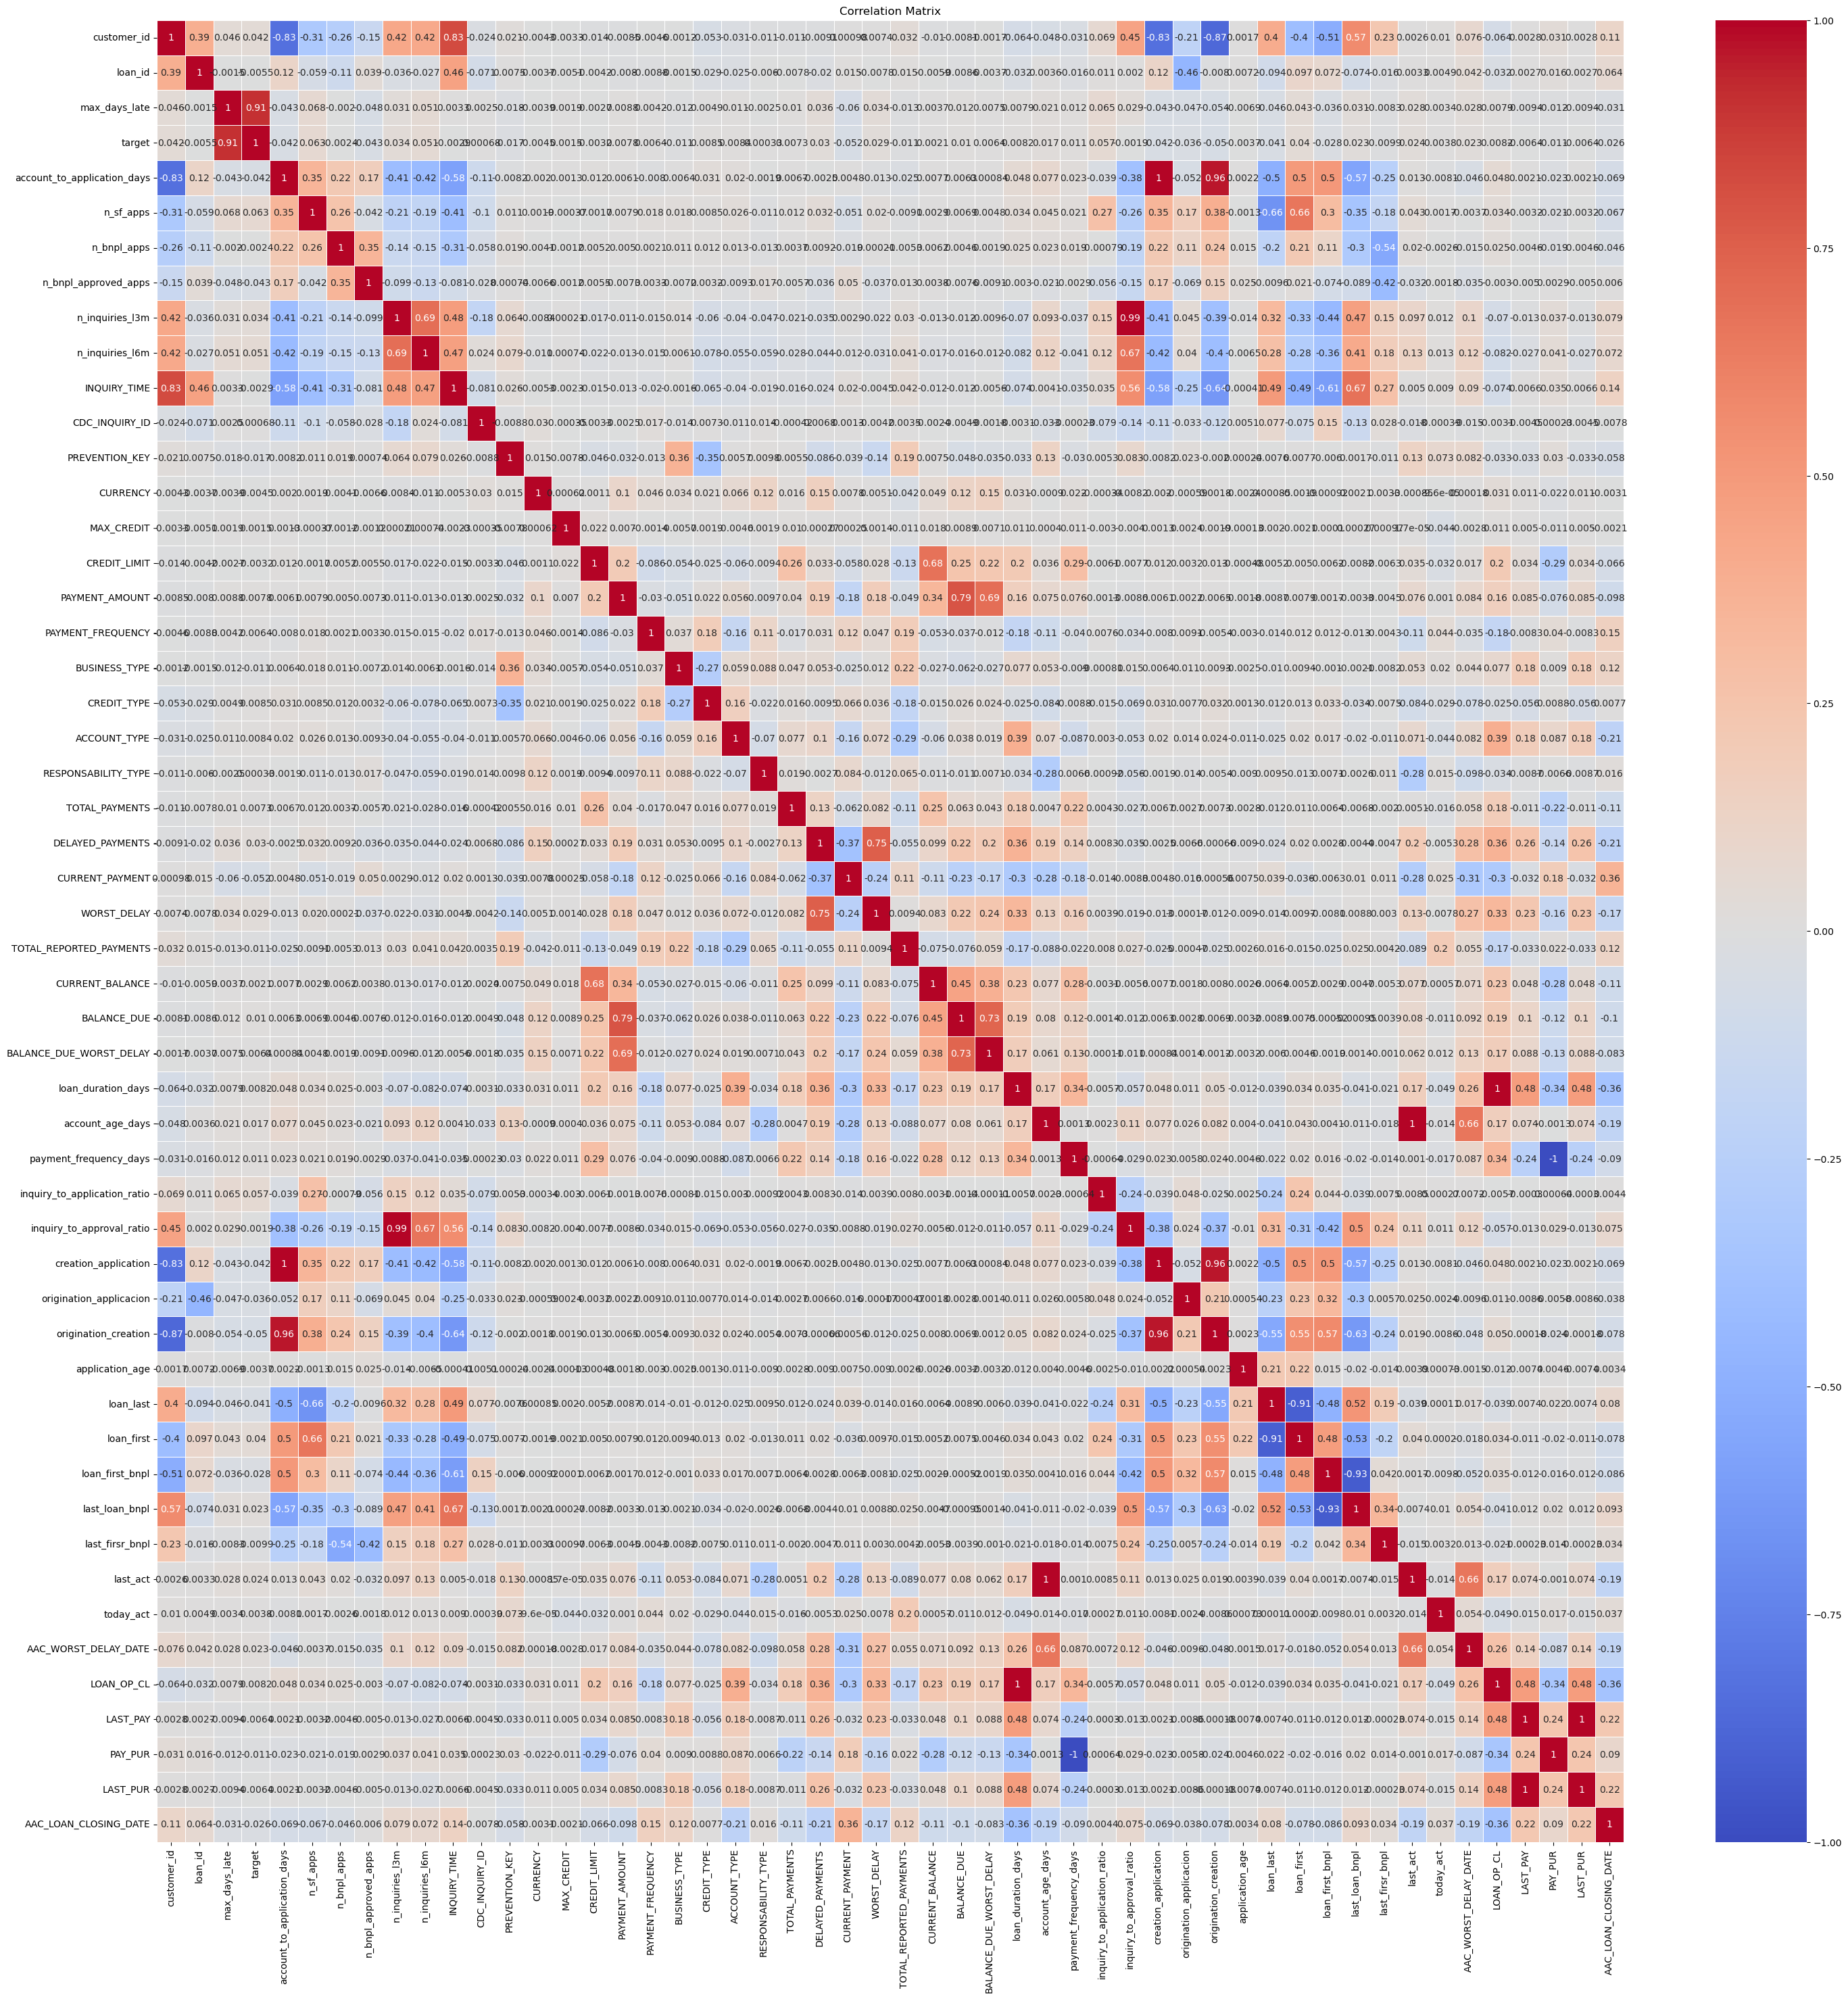

In [38]:
correlation_matrix = merged_df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(35, 35))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')

In [39]:
df=merged_df.copy()

In [40]:
# Identifica las columnas que son del tipo datetime
columnas_datetime = merged_df.select_dtypes(include=['datetime64']).columns

# Define una fecha de referencia (puede ser cualquier fecha que elijas)
fecha_referencia = pd.to_datetime(datetime.now().date())

# Itera sobre las columnas datetime y convierte las fechas a un valor numérico (diferencia de días desde la fecha de referencia)
for columna in columnas_datetime:
    merged_df[columna] = (merged_df[columna] - fecha_referencia).dt.total_seconds() / (60 * 60 * 24)



In [41]:
merged_df.drop("max_days_late", axis=1, inplace=True)
#Eliminamos la variable de max_days_late, ya que esta esta altamente correlacionada con el target, por lo cual el modelo no lograria aprender el comportamiento completo

### Modelo: 
HistGradientBoostingClassifier

In [42]:

# 2. División de datos en conjunto de entrenamiento y prueba
X = merged_df.drop('target', axis=1)  # Variables predictoras
y = merged_df['target']  # Columna objetivo (etiquetas de clasificación)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Terminé el paso de división de datos")

# 3. Definición del modelo de HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(random_state=42)

print("Terminé el paso 3")

# 4. Definición de los hiperparámetros para Grid Search
param_grid = {
    'max_iter': [300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
}

print("Terminé el paso 4")

# 5. Configuración de Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='precision')
print("Terminé el paso 5")

# 6. Entrenamiento del modelo con Grid Search
grid_search.fit(X_train, y_train)
print("Terminé el paso 6")

# 7. Mejor modelo encontrado por Grid Search
best_model = grid_search.best_estimator_
print("Terminé el paso 7")

# 8. Evaluación del modelo
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"precision: {precision}")
print("Matriz de confusión:")
print(conf_matrix)

print("Terminé el paso 8")


Terminé el paso de división de datos
Terminé el paso 3
Terminé el paso 4
Terminé el paso 5
Terminé el paso 6
Terminé el paso 7
precision: 0.999322951929587
Matriz de confusión:
[[47772     6]
 [  838  8856]]
Terminé el paso 8


In [43]:
best_model.get_params

<bound method BaseEstimator.get_params of HistGradientBoostingClassifier(max_iter=500, min_samples_leaf=4,
                               random_state=42)>

Se realizo una validación cruzada asi como la división de datos para asegurar que el modelo no solo tuviera buenos resultados como los antes presentados, si no tambien, lograr la variabilidad y evitar el sobreajuste. 

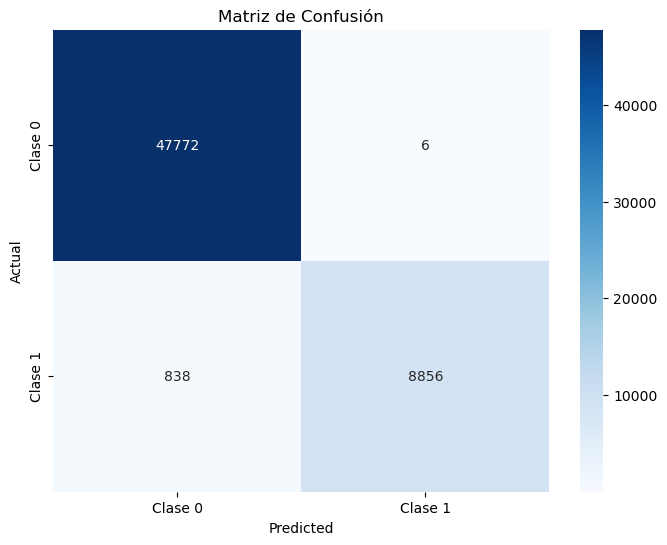

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

# Usar Seaborn para crear un mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])

# Configurar etiquetas y título
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

# Mostrar la matriz de confusión
plt.show()

In [45]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       0.98      1.00      0.99     47778
     Clase 1       1.00      0.91      0.95      9694

    accuracy                           0.99     57472
   macro avg       0.99      0.96      0.97     57472
weighted avg       0.99      0.99      0.99     57472



In [46]:
num_filas = merged_df.shape[0]
print(f"El número de filas en merged_df es: {num_filas}")


El número de filas en merged_df es: 287356


Podemos observar que el 20% de los datos son los que se utilizaron, esto permite validar que los resultados del modelo, son muy buenos, pero son congruentes y sin "trampas" de que este observando datos aprendidos.

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred)

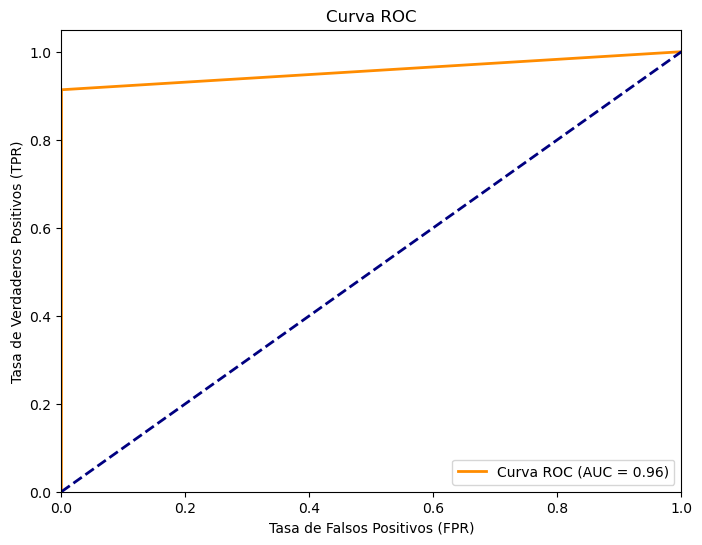

In [48]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred)

# Crear la gráfica de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

La curva ROC (Receiver Operating Characteristic) es una representación gráfica que se utiliza en el análisis de clasificadores binarios. El AUC que se obtuvo fue de 0.96 lo cual indica un excelente rendimiento del clasificador en términos de su capacidad para distinguir entre las dos clases.

Calculamos el Area bajo la curva PR la cual nos permite medir la capacidad del modelo para recuperar ejemplos positivos y se basa en la curva PR¿

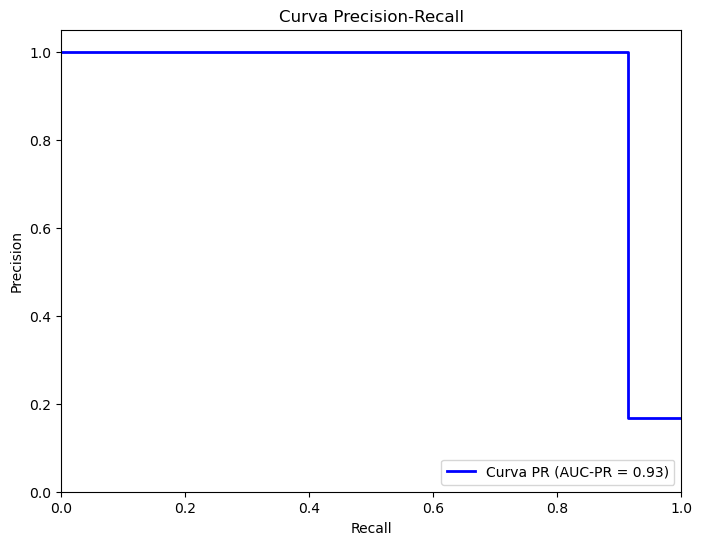

In [49]:
# Calcular la curva PR
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calcular el área bajo la curva PR (AUC-PR)
pr_auc = average_precision_score(y_test, y_pred)

# Crear la gráfica de la curva PR
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', lw=2, label=f'Curva PR (AUC-PR = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curva Precision-Recall')
plt.legend(loc="lower right")
plt.show()


Elk AUC-PR que se obtuvo del modelo fue de 0.93 lo cual es un indicativo positivo del rendimiento del clasificador. 

Por lo cual podemos concluir que tiene: 

Alta precisión: Un AUC-PR de 0.93 indica que el clasificador tiene una alta capacidad para clasificar correctamente las instancias positivas, es decir, cuando predice que una instancia es positiva, tiende a ser correcto en un 93% de las veces. Lo cual para el ejercicio se traduce que aproximadamente solo el 7% de las personas a las cuales se les considere con un scoring crediticio representan un posible riesgo para la compañía.

Buen recall: El AUC-PR también mide el recall, que se refiere a la capacidad del clasificador para identificar la mayoría de las instancias positivas en el conjunto de datos. Un AUC-PR de 0.93 significa que el clasificador tiene un buen equilibrio entre la precisión y el recall, lo que sugiere que no solo es preciso, sino que también identifica la mayoría de las instancias positivas.

Buen rendimiento global: En general, un AUC-PR de 0.93 indica un buen rendimiento del clasificador en términos de su capacidad para identificar correctamente las instancias de la clase positiva y minimizar los falsos positivos.

Esto nos indica un clasificador sólido con un buen equilibrio entre precisión y recall

Realizamos el coeficiente Kappa (Cohen's Kappa) que nos ayude a medir la concordancia entre las predicciones del modelo y las etiquetas reales, teniendo en cuenta la concordancia esperada por azar. 

Este coeficiente se espera de valor uno, por los resultados obtenidos anteriormente, sin embargo este puede variar si el modelo no es "estable" y guiandose por una regla de posicionamiento no antes observada

In [50]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred)
kappa

0.945780766993808

El kappa de 0.9457 sugiere que hay una coincidencia sustancial y confiable entre las observaciones o clasificaciones, lo cual da una alta fiabilidad y concordancia en las predicciones realizadas.

#### ¿Por que se utilizo HistGradientBoostingClassifier?

Los motivos por los cuales elegí dicho modelo son:


1.- Rendimiento eficiente, ya que este modelo esta optimizado para grandes conjuntos de datos y a su vez hacer predicciones rápidas, el cliente no esperará mucho tiempo para saber si su credito fue o no aprobado, y si bien este modelo no decidirá por si solo la aceptación o no del credito, si será parte de los inputs para tomar la decisión.

2.- Manejo de los datos no balanceados, como se observa en el EDA, los datos no son balanceados, tenemos más del 80% de los datos en una etiqueta 0, lo cual podemos interpretar como la cantidad de personas que llevan un buen credito, por lo cual es vital para el ejercicio considerar dicho desequilibrio.

3.- Buenos Resultados, los algoritmos de tipo Gradient Boosting suelen tener buenos resultados y rendimiento predictivo, lo cual es crucial para este tipo de aplicaciónes donde buscamos identificar a los solicitantes de crédito de alto riesgo.



#### ¿Este modelo se podria implementar por si solo?

No, este modelo no serviria para determinar si se le da el credito a una persona o no, ya que no se puede obtener por su naturaleza de biblioteca las caracteristicas importantes que esta considerando para dar o no el credito. Para eso se debería de tener una sesión con riesgo crediticio, y evaluar la forma de imputar correctamente los datos, para cambiar el modelo por un gradint bossting Classifier y de esa manera observar cuales son las caracteriticas que son más relevantes para el mismo, esto es algo que se debe de poder auditar para poder llevarlo con cliente y ante la comisión bancaria y de valores.

#### Sugerencias

De acuerdo a workshops con negocio y riesgo crediticio poder evaluar el scoring credit de una forma no binaria, esto quiere decir que podamos obtener un scoring de cada cliente por medio de un número decimal, que vaya de 0 a cero riesgo a 1, muy riesgozo, pudiendo de esta manera evaluar la posibilidad de dar bajos creditos a personas que no tengan el mejor historial, con esto podriamos hacer más inclusivas las posibilidades, aumentando nuestra cartera de clientes.

Consideremos que de acuerdo a una evaluación hecha pre-pandemia por el Econocmista, la cual encuestio a 400,000 personas mexicanas, menos del 20% de las personas puden comprobar un score crediticio positivo o excelente, lo cual excluye a la mayoria de la población.


liga: https://www.eleconomista.com.mx/finanzaspersonales/Mexicanos-se-endeudan-en-promedio-por-35000-pesos-20190701-0093.html